In [1]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy

In [2]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
api = wandb.Api(timeout=200)

In [4]:
relabels = {
    "xppo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "basline_ppo_10m": "PPO-clip",
    "xppo_single_step_4096": "xPPO",
    "basline_stbl_ppo": "PPO-clip",
    'xppo_single_step_large_historic': "xPPO $|D_{h}|=128000$",
    "xppo_single_step_no_historic": "xPPO $|D_{h}|=4096$",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    'env': "Environment",
    'rollout/SuccessRate':'Average Success Rate',
    'train/std': "Action Distribution STD",
    "<SawyerPushEnvV2 instance>":"push",
    "<SawyerWindowCloseEnvV2 instance>":"window-close",
    "<SawyerDoorEnvV2 instance>":"door-open",
    "<SawyerReachEnvV2 instance>":"reach",
    "<SawyerButtonPressTopdownEnvV2 instance>":"button-press-topdown",
    "<SawyerWindowOpenEnvV2 instance>":"window-open",
    "<SawyerDrawerOpenEnvV2 instance>":"drawer-open",
    "<SawyerPegInsertionSideEnvV2 instance>":"peg-insert-side",
    "<SawyerDrawerCloseEnvV2 instance>":"drawer-close",
    "train/explained_variance": "Explained Variance",
}
envs = ["<SawyerPushEnvV2 instance>",
"<SawyerWindowCloseEnvV2 instance>",
"<SawyerDoorEnvV2 instance>",
"<SawyerReachEnvV2 instance>",
"<SawyerButtonPressTopdownEnvV2 instance>",
"<SawyerPickPlaceEnvV2 instance>",
"<SawyerWindowOpenEnvV2 instance>",
"<SawyerDrawerOpenEnvV2 instance>",
"<SawyerPegInsertionSideEnvV2 instance>",
"<SawyerDrawerCloseEnvV2 instance>",]

In [5]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter):
    all_interp_data = []
    for group, x_key, y_key in group_and_keys:
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"group": group},
                    {"$not": {"tags": "exclude-from-paper"}},
                    extra_filter,
                ]
            },
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        skipped = 0
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.9 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                    skipped += 1
                    continue
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                all_interp_data.append(
                    pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                )
        print("Group", group, "had", len(runs) - skipped, "good runs")
    return pd.concat(all_interp_data, ignore_index=True)

## Pick-Place

In [6]:
env = "PickPlace-V2"
env = "PickPlace-V2"
config_env = "<SawyerPickPlaceEnvV2 instance>"
total_steps=10e6
group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "train/explained_variance"),
    ("basline_stbl_ppo", 'global_step', "train/explained_variance")
]
state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
# state_env_filter = {"$and": [state_filter, env_filter]}
state_env_filter = {"$and": [env_filter]}


baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, state_env_filter]}

extra_filter = {"$or": [env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 43 runs for group xppo_single_step_4096
Maximum x value of run <Run resl-mixppo/stabilized-rl/qrh6xh7x (crashed)> is 2158592.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/f2me2qrm (crashed)> is 2777088.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/467hrmvh (crashed)> is 3211264.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/dykbgzlj (crashed)> is 2080768.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/9twcs1os (crashed)> is 2052096.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/tqlflky9 (crashed)> is 2170880.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/q4r7gpqq (crashed)> is 2113536.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/g0zjxihl (failed)> is 6164480.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/0y8q0nz1 (crashed)> is 2228224.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/cynct45o (failed)> is 3215360.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/c46fdn5r (failed)> is 8192
Maximum

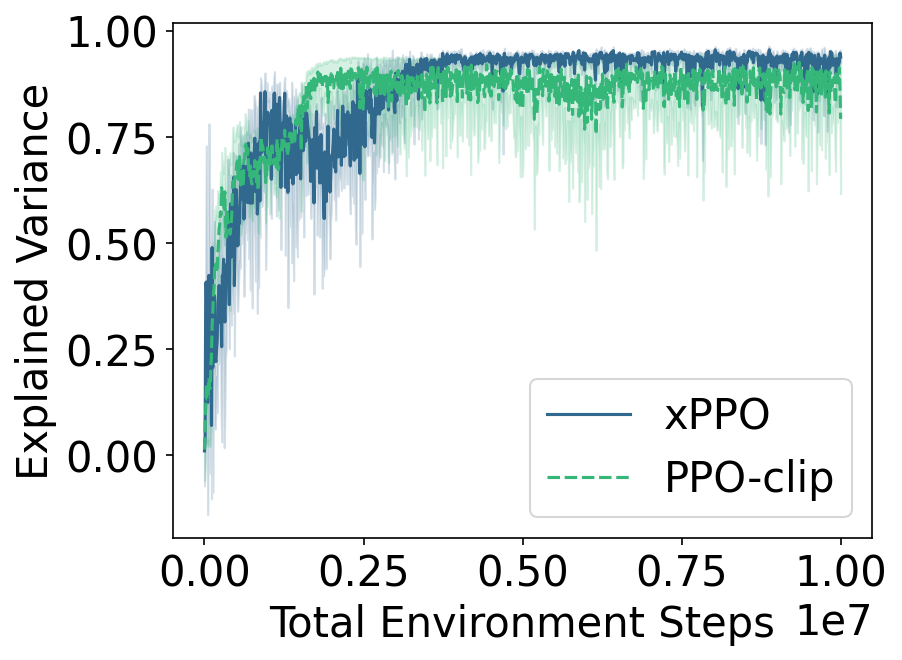

In [8]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Explained Variance",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}_exp_variance.pdf")

## Window-Open

In [13]:
env = "WindowOpen-V2"
config_env="<SawyerWindowOpenEnvV2 instance>"
total_steps=5e6

group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "train/explained_variance"),
    ("basline_stbl_ppo", 'global_step', "train/explained_variance")
]

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, env_filter]}

extra_filter = {"$or": [env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 56 runs for group xppo_single_step_4096
Maximum x value of run <Run resl-mixppo/stabilized-rl/vhiswhrt (failed)> is 2883584.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/z85zfzt0 (crashed)> is 2592768
Maximum x value of run <Run resl-mixppo/stabilized-rl/qgpgqrls (finished)> is 3002368.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/nzs4cvs5 (finished)> is 3002368.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/7bnk8uaf (crashed)> is 2584576.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/w6ict3s4 (crashed)> is 2600960.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/owl96p1e (finished)> is 3002368.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/bbrl6zx3 (crashed)> is 2564096.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/oh1tqivj (finished)> is 2613248.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/rexy6po5 (crashed)> is 2625536.0
Maximum x value of run <Run resl-mixppo/stabilized-rl/owipiei1 (crashed)> is 2498560


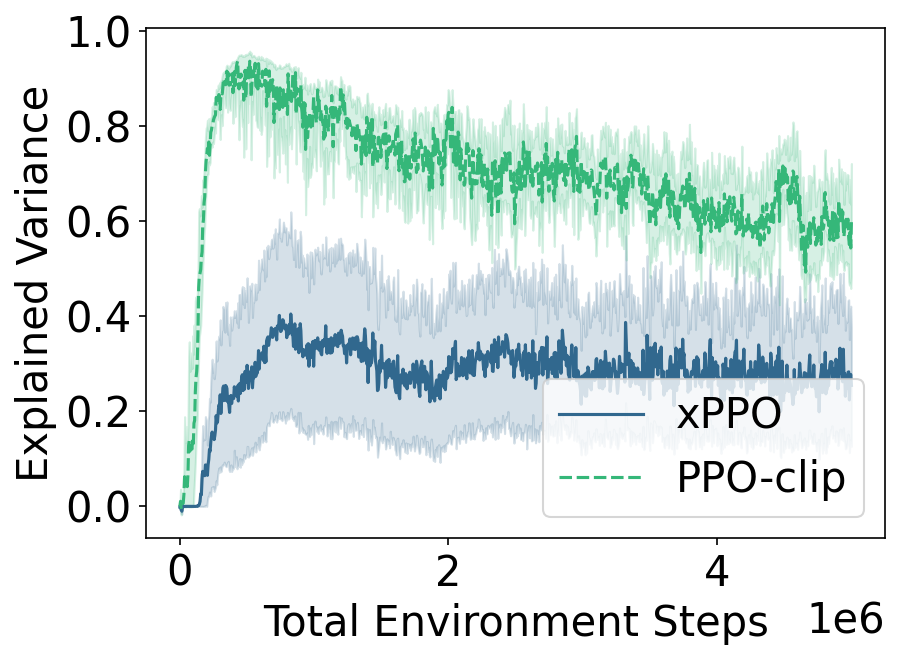

In [14]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Explained Variance",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")

plt.tight_layout()
plt.tight_layout()

plt.savefig(f"XPPO_vs_ppo_{env}_exp_variance.pdf")

## Reach

In [15]:
env = "Reach-V2"
config_env="<SawyerReachEnvV2 instance>"
total_steps=1e6

group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "train/explained_variance"),
    ("basline_stbl_ppo", 'global_step', "train/explained_variance")
]

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, env_filter]}

extra_filter = {"$or": [env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

Got 42 runs for group xppo_single_step_4096
Maximum x value of run <Run resl-mixppo/stabilized-rl/jx4pwegk (failed)> is 12288
Maximum x value of run <Run resl-mixppo/stabilized-rl/hdtr2gtm (failed)> is 20480
Maximum x value of run <Run resl-mixppo/stabilized-rl/3dz967vz (failed)> is 28672
Maximum x value of run <Run resl-mixppo/stabilized-rl/y73h3zu9 (failed)> is 36864
Maximum x value of run <Run resl-mixppo/stabilized-rl/uh9qai9v (failed)> is 36864
Maximum x value of run <Run resl-mixppo/stabilized-rl/89vkh1hx (failed)> is 53248
Maximum x value of run <Run resl-mixppo/stabilized-rl/8uwmpjs2 (killed)> is 192512
Group xppo_single_step_4096 had 35 good runs
Got 27 runs for group basline_stbl_ppo
Could not get keys in run <Run resl-mixppo/stabilized-rl/ymzohxc1 (failed)>
Empty DataFrame
Columns: []
Index: []
Could not get keys in run <Run resl-mixppo/stabilized-rl/eu4sqymw (failed)>
Empty DataFrame
Columns: []
Index: []
Could not get keys in run <Run resl-mixppo/stabilized-rl/kad2grce (fa

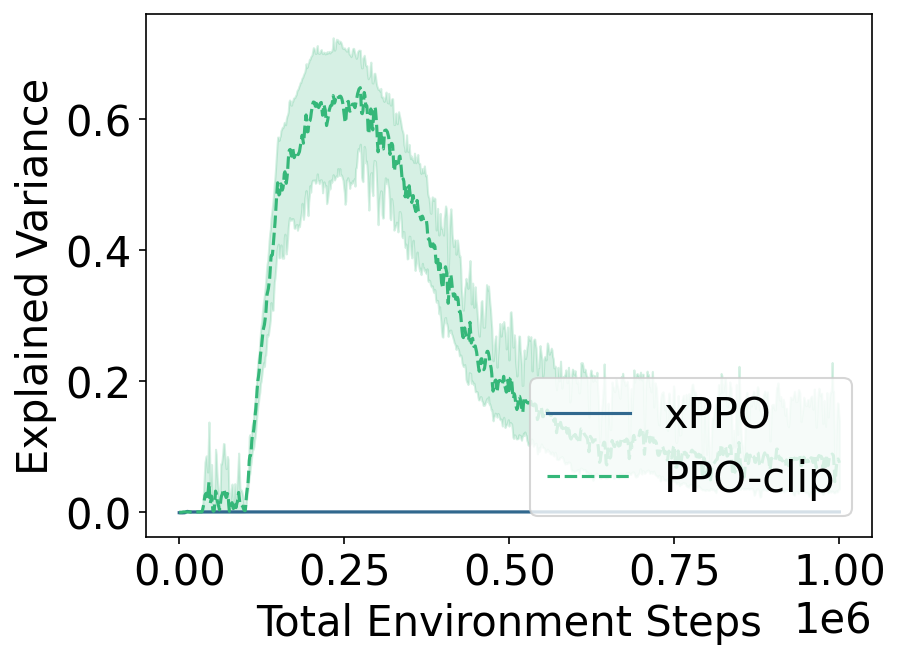

In [16]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Explained Variance",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"XPPO_{env}_exp_variance.pdf")

In [ ]:
runs = list(api.runs(
            path="resl-mixppo/stabilized-rl",
            filters={
                "$and": [
                    {"state": "running"},
#                     {"$not": { "hostname": "stygian" }},
#                     {"system/proc.memory.rssMB": { "$gt": 1999 } },
                ]
            },
        ))

In [ ]:
for r in runs:
    last_timestamp = r.history(keys=["_timestamp"])["_timestamp"].max()
    if last_timestamp < time.time() - 10 * 60:
        print(r.to_html())

In [ ]:
import time

In [ ]:
time.time()

In [ ]:
time.time()

In [ ]:
r.display()

In [ ]:
r.history()

In [ ]:
env = "Reach-V2"
config_env="<SawyerReachEnvV2 instance>"
total_steps=1e6

group_and_keys = [
    ("xppo_single_step_4096", "global_step",  "train/explained_variance"),
    ("basline_stbl_ppo", 'global_step', "train/explained_variance")
]

state_filter = {"$or": [{"state": "finished"}, {"state": "running"}]}
env_filter = {"config.env":config_env}
# extra_filter = {"tags": {"$in": ["xppo_pick-place", 'stbl_ppo_pick-place_baseline']}}
state_env_filter = {"$and": [state_filter, env_filter]}

baseline_n_steps_filter = {"$and":[{'config.n_steps': 50_000}, {'group':'basline_stbl_ppo'}, env_filter]}

extra_filter = {"$or": [env_filter, baseline_n_steps_filter]}
all_data = load_groups(
    group_and_keys,
    relabels,
    (0, total_steps),
    extra_filter
)

In [ ]:
matplotlib.rcParams["font.size"] = 18
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Explained Variance",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"XPPO_vs_PPO_explained_variance_{env}.pdf")